# Bike Share System Usage
CMSC320 Final Project
By: Jessica Lee, Kelly Li


## Contents
1. Introduction
2. Libraries Used
3. Dataset
4. Importing Data
5. Data Cleaning
6. Data Exploration

## Introduction

Bike share programs are a type of shared public transporatation system that is considered to be eco-friendly and sustainable. Typically these systems work by allowing people to rent bikes at a station, travel to their destination, and return the bike to another station. Such bike programs are frequently implemented in more densly populated areas such as cities, and have been relatively successful. Majority of revenue is from bike users and the the length of time they borrow a bike. This leads to the question: **what factors influences the number of bike trips in bike ahre systems?** Knowing this can allow us to see what business strategies can be used to optimize the conditions in which people use bike share programs and potentially incentivize people to use these more.

In this tutorial, our goal is to create a walkthrough of the data science lifecycle and show how data science tools and techniques can be used to answer this particular question.


## Libraries Used  
In this tutorial, we used the following libraries:
* sqlite3
* pandas
* numpy
* matplotlib
* folium
* json

Please also note we are also using Python [version]

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json 

## Dataset
The dataset used was obtained from Kaggle and is a dataset on a bike share program in San Francisco bay area. It contains 2 years of anonymized bike trip data from August 2013 to August 2015. In total, there are 4 tables: station, status, trip, and weather.

Station has a total of 70 rows and 7 columns. This consists of data that represent stations where users can borrow and return bikes. Status has a total of 71,984,434 rows and 4 columns. This consists of minute by minute data about the number of bikes and docks avaliable at each station. Due to the sheer size of this table, we chose to not include any data contained in this table due to limits in computing power. Trip has a total of 669,959 rows and 11 columns. This consists of individual bike trip data. Weather has a total of 3665 rows and 24 columns. It consists of data about the weather on a particular day for specific zipcodes.

More information on the origin of the dataset can be found here: [SF Bay Area Bike Share Data](https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share)

## Importing Data
After obtaining our data from Kaggle, our next step is to import our data into pandas dataframes. Our data from Kaggle includes a zip file that we unzipped locally, which contains a sqlite version of the data and csv version of the data. Below, we decided to import our data sqlite file, however, we can also just read the csv files with `<dataframe> = pd.read_csv(<file path>)` for all csv files.

We first verify that the sqlite file contains all tables. We obtain a list of table names, which reveal the tables to be station, status, trip, and weather as expected.

In [2]:
# create connection to sqlite file
con = sqlite3.connect("database.sqlite")

# get tables
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor = con.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[('station',), ('status',), ('trip',), ('weather',)]


To extract an entire table, we use SQL statements to pull all rows from each table, and insert those into a dataframe. Note that for this tutorial we will only be using 3 of the 4 tables for reasons mentioned in the previously. We can then output the columns as well as a few rows of each dataframe to get a general idea what data is available in each extracted table.

In [3]:
#station = pd.read_sql_query("SELECT * from station", con)
#trip = pd.read_sql_query("SELECT * from trip", con)
#weather = pd.read_sql_query("SELECT * from weather", con)


# if you would like to try out reading from csv files, you can try uncommenting the code segment below!

station = pd.read_csv("station.csv")
trip = pd.read_csv("trip.csv")
weather = pd.read_csv("weather.csv")

station_backup = station.copy(deep=True)
trip_backup = trip.copy(deep=True)
weather_backup = weather.copy(deep=True)

In [4]:
print(station.dtypes)
station.head()

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object


,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [5]:
print(trip.dtypes)
trip.head()

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [6]:
print(weather.dtypes)
weather.head()

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches               object
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


## Data Cleaning

After importing the data, our next step is to clean it. From the above, we see some of the data types for the columns are not ideal and would want to transform them to be something easier to use before performing analysis. However data cleaning is a continuous cycle, thus what we performed in this section is just preliminary data cleaning, and we will continue to perfrom cleaning as we discover more about the data.

We also take this opportunity to create some of our own columns based on existing data to make our analysis later easier. We do this by "binning" which is introducing a new categorical variable that can possibly provide new information. 

In [7]:
# Clean for missing data, remove any rows with missing data
station = station.dropna()
trip = trip.dropna()
weather = weather.drop('events', axis=1)
weather = weather.dropna()

# Convert weather data to numeric values
weather = weather.apply(pd.to_numeric, errors='ignore')
#trip['zip_code'] = pd.to_numeric(trip['zip_code'])

# Convert dates from string to datetime objects
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
weather['date'] = pd.to_datetime(weather['date'])

# Add a column for start date without time
trip["date"] = trip['start_date'].apply(lambda x: x.date())
trip['date'] = pd.to_datetime(trip['date'])

# Binning by month using the start date
trip['month'] = trip['start_date'].apply(lambda x: x.month)



## Data Exploration

In this part, our goal is to explore our data and get a better understanding of the different variables and some of their relationships

To get a better understanding of the bike program, we can first map out the location of all stations.

In [8]:
# mark all the stations
map_osm = folium.Map(location=[37.580000, -122.28000], zoom_start=10)

for index, station_info in station.iterrows():
    tooltip_text = station_info['name'] + "\n"
    folium.Marker(location=[station_info["lat"], station_info["long"]], tooltip=tooltip_text).add_to(map_osm)
    
map_osm

From the map output, it appears there are 5 clusters: San Francisco, San Jose, Redwood City, Mountain View, and Palo Alto. Thus, we can see that the bike share stations are not evenly distributed geographically. We can hover above each marker to obtain the name of the station indicated by the marker. 

We can also take a look at the trip data. We first output some summary stats to get a general idea.

In [9]:
trip.describe()

,id,duration,start_station_id,end_station_id,bike_id,month
count,663340.000000,6.633400e+05,663340.000000,663340.000000,663340.000000,663340.000000
mean,463849.196803,1.077212e+03,57.856609,57.841721,427.475040,6.459206
std,263236.718344,2.233404e+04,17.124582,17.212950,153.612018,3.269637
min,4069.000000,6.000000e+01,2.000000,2.000000,9.000000,1.000000
25%,237254.750000,3.430000e+02,50.000000,50.000000,334.000000,4.000000
50%,463612.500000,5.140000e+02,62.000000,62.000000,440.000000,7.000000
75%,694728.250000,7.490000e+02,70.000000,70.000000,546.000000,9.000000
max,913460.000000,1.727040e+07,84.000000,84.000000,878.000000,12.000000


In this case, the summary statatistics for ID related columns do not mean much. However, duration appears to be interesting where the mean is approximately 1108. This leads to the question what are the units? It does not appear to be in minutes or units of anything larger. Thus we can temporarily assume it is seconds and attempt to convert into minutes, and see if it gives reasonable results.

In [10]:
trip['duration'] = trip['duration'].apply(lambda x: x / 60)
trip.describe()

,id,duration,start_station_id,end_station_id,bike_id,month
count,663340.000000,663340.000000,663340.000000,663340.000000,663340.000000,663340.000000
mean,463849.196803,17.953531,57.856609,57.841721,427.475040,6.459206
std,263236.718344,372.233985,17.124582,17.212950,153.612018,3.269637
min,4069.000000,1.000000,2.000000,2.000000,9.000000,1.000000
25%,237254.750000,5.716667,50.000000,50.000000,334.000000,4.000000
50%,463612.500000,8.566667,62.000000,62.000000,440.000000,7.000000
75%,694728.250000,12.483333,70.000000,70.000000,546.000000,9.000000
max,913460.000000,287840.000000,84.000000,84.000000,878.000000,12.000000


From the new mean of the duration, it appears our guess was correct that the original units was in seconds since it appears reasonable the duration of a bike trip can be around 17 minutes. The max being 287,840 minutes imply there is at least one outlier. With 75% of our bike trip duration data to be around 12.5 minutes or less, yet our mean is greater than 12.5 means our data is very skewed. Thus we can attempt to plot the distribution of the biking times to be at most 1 hours to better understand duration trends without the interference of outliers.

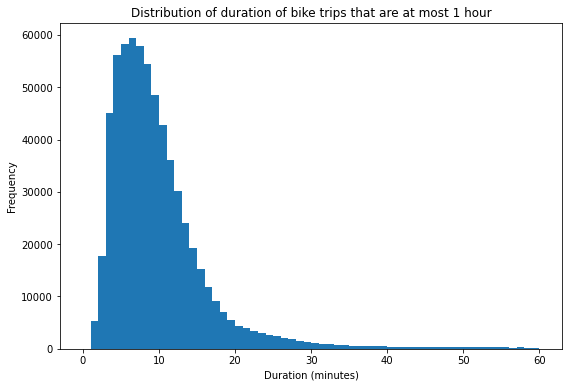

In [11]:
# histogram of the biking time duration for trips of length 1 hour
# Label points and change plot size
fig, ax = plt.subplots(figsize = (9, 6))
plt.hist(trip['duration'], bins = 60, range=[0, 1 * 60])

# Graph labels and titles
plt.title('Distribution of duration of bike trips that are at most 1 hour')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

As expected, our histogram does reveal that our data is skewed, and has a relatively long right tail. 

The next thing we consider is the frequency of the bike trips. Is the number of bike trips a seasonal pattern?
To do this, we can use the bins we created by month to construct another visualization that allows us to compare the number of bike trips per month.

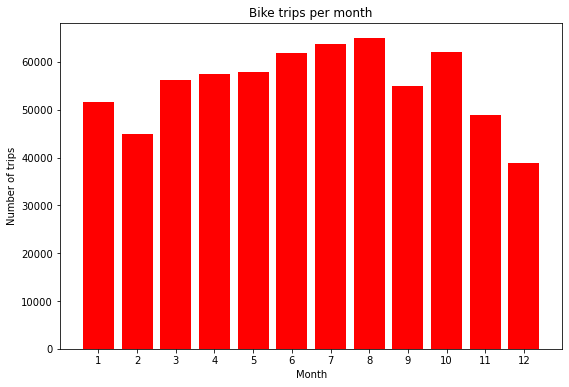

In [12]:
# number of bike trips per month
# Label points and change plot size
fig, ax = plt.subplots(figsize = (9, 6))
plt.bar(range(1, 13), np.bincount(trip['month'], minlength=13)[1:], color='red')

# Graph labels and titles
plt.title('Bike trips per month')
plt.xlabel('Month')
plt.ylabel('Number of trips')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.show()


We observe that December seems to be the month with the least bike trips and August is the month that has the most bike trips out of all other months. There seems to be a general trend where spring and summer months have more bike trips than the fall and winter months.

Thus does months also have any relationship with bike trip duration? We can visualize this with a series of box plots to see if there is.

Note for the boxplot graphed, the whiskers by default "extend no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval" according to doucmentation on the boxplot function found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html).

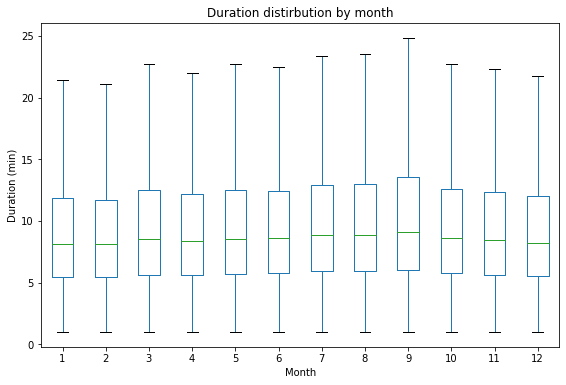

In [13]:
# Show distribution of bike duration per month via box plots

ax = trip[['month', 'duration']].boxplot(by='month', grid=False, showfliers=False, figsize=(9, 6), return_type='axes')
plt.title("Duration distirbution by month")
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Duration (min)')
plt.show()

Plotting it out, it does not seem like there are any interesting trends here. The biking duration accross all months looks about the same. The median duration of bike trips are indicated by the gren line in box are approximately the same for all months.

Before moving on to explore another table, we can consider other trends not involving time. Who are the riders for the bike trip?

In [14]:
trip['subscription_type'].value_counts()

Subscriber    566746
Customer       96594
Name: subscription_type, dtype: int64

Next, we can explore the weather table a bit. One thing we do know from the dataset description is that we only have weather data for certain zipcodes. So what does that mean? We can start by printing out the possible values for zipcodes.

In [15]:
weather['zip_code'].value_counts()

94041    722
95113    721
94107    720
94063    321
94301    270
Name: zip_code, dtype: int64

Interestingly, we only have 5 zipcodes. We notice that zipcode 94063 and 94031 seem to have missing data since its occurances appear to be significantly different. Does this align with the zipcodes in the trip data?

In [16]:
trip['zip_code'].value_counts()

94107    78704
94105    42672
94133    31359
94103    26673
94111    21409
         ...  
7020         1
99770        1
83200        1
2751         1
17042        1
Name: zip_code, Length: 7439, dtype: int64

We notice that there is significantly more unique zipcodes in the trip data, thus we need to also bin trip by the closest zipcode. We can try to first bin this visually by creating another map that highlights where the zip code areas are. we notice that there are 5 zipcodes, and earlier we observed there are 5 clusters for station. Let us try to graph each station cluster individually and determine if these observations are related.

We first start by importing a file that can visually  represent zipcode regions on a map. This file is a geojson file, and was obtained from the San Francisco government website and contains zipcode boundaries for the Bay Area. The source link can be found [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-ZIP-Codes/u5j3-svi6)

In [17]:
# load GeoJson

zipcode_map_data= 0

with open('Bay Area ZIP Codes.geojson', 'r') as jsonFile:
    zipcode_map_data = json.load(jsonFile)


After loading in the zipcode boundary data, we can filter it for the zipcodes we are interested in.

In [18]:
# create a list of zipcodes in weather 
zip_list = ['94041', '95113', '94107', '94063', '94301']

# extract zip boundaries for the zipcodes we have
new_zip_map_data = []
for i in range(len(zipcode_map_data['features'])):
    if zipcode_map_data['features'][i]['properties']['zip'] in zip_list:
        new_zip_map_data.append(zipcode_map_data['features'][i])

# create new JSON
zipcode_map_data2 = dict.fromkeys(['type', 'features'])
zipcode_map_data2['type'] = 'FeatureCollection'
zipcode_map_data2['features'] = new_zip_map_data
      

In [19]:
# function mark all the stations per region
def add_marker_for_region(region):
    for index, station_info in station.iterrows():
        if station_info['city'] == region:
            tooltip_text = station_info['name'] + "\n"
            folium.Marker(location=[station_info["lat"], station_info["long"]], tooltip=tooltip_text).add_to(map_osm)   
    
# Map San Francisco 
map_osm = folium.Map(location=[37.7749, -122.4194], zoom_start=13)
add_marker_for_region('San Francisco')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

/opt/conda/lib/python3.9/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [20]:
# Map San Jose
map_osm = folium.Map(location=[37.3387, -121.8853], zoom_start=13)
add_marker_for_region('San Jose')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

In [21]:
# Map Redwood City
map_osm = folium.Map(location=[37.4848, -122.2281], zoom_start=13)
add_marker_for_region('Redwood City')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

In [22]:
# Map Mountain View
map_osm = folium.Map(location=[37.3861, -122.0839], zoom_start=13)
add_marker_for_region('Mountain View')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

In [23]:
# Map Palo Alto
map_osm = folium.Map(location=[37.4419, -122.1430], zoom_start=13)
add_marker_for_region('Palo Alto')

map_osm.choropleth(
    geo_data = zipcode_map_data2,
    fill_opacley = 0.5,
)

map_osm

From the 5 maps of the different station clusters above, it does appear to align with our theory that the weather data aligns with a group of stations by the cluster they are in. We can add this newly discovered information to our dataframes by binning technique again.

We start by first mapping the zipcodes to the corresponding city regions in a dictionary. A quick Google search on Google allows us to determine what zipcodes correspond to what city region:  
* Mountain View : 94041
* San Jose : 95113
* San Francisco : 94107
* Redwood City : 94063
* Palo Alto : 94301

In [24]:
# associate the zipcodes zip_list = ['94041', '95113', '94107', '94063', '94301'] to one of the 5 cities: 
# San Francisco, San Jose, Redwood City, Mountain View, and Palo Alto

city_dict1 = {'94041':'Mountain View', '95113':'San Jose', '94107':'San Francisco', '94063':'Redwood City', '94301':'Palo Alto'}
city_dict2 = {'Mountain View':'94041', 'San Jose':'95113', 'San Francisco':'94107', 'Redwood City':'94063', 'Palo Alto':'94301'}

# we add the city mapping to a zipcode
station['zipcode'] = station['city'].apply(lambda x: city_dict2[x])

# we add zipcode to city mapping in weather
weather['city'] = weather['zip_code'].apply(lambda x: city_dict1[str(x)])


In [25]:
# we assign a bin for each trip based on start location station

station_tmp =  station[['id', 'name', 'city', 'zipcode', 'dock_count']]

# we can use the bins as keys to merge all our data into one dataframe!
# merge station info into trip data
trip_tmp = pd.merge(left=trip,right=station_tmp, how = "inner", \
                    left_on = ['start_station_id', 'start_station_name'], right_on = ['id', 'name'])
trip_tmp.rename(columns={'id_x': 'trip_id', 'zipcode' : 'city_zip'}, inplace=True)

# remove duplicate column from merge key
trip_tmp = trip_tmp.drop('id_y', axis=1)
trip_tmp = trip_tmp.drop('name', axis=1)

# merge weather info into trip data
# convert weather zipcode to string to ensure data type alignment
weather['zip_code'] = weather['zip_code'].apply(lambda x: str(x))

trip_tmp = pd.merge(left=trip_tmp, right=weather, how = "inner", left_on=['date', 'city', 'city_zip'],\
                   right_on = ['date', 'city', 'zip_code'])
trip_tmp.rename(columns={'zip_code_x': 'trip_zip_code'}, inplace=True)
trip_tmp = trip_tmp.drop('zip_code_y', axis=1)


In [26]:
# to perform a classification problem on predicting if a bike trip is made by subscriber or customer:
# we merge all weather data to trip table
trip_all_data = trip_tmp.copy(deep=True)
trip_all_data = trip_all_data.drop('trip_id', axis=1)
trip_all_data = trip_all_data.drop('start_date', axis=1)
trip_all_data = trip_all_data.drop('end_date', axis=1)


In [27]:
trip_all_data['day_of_week'] = trip_all_data['date'].apply(lambda x: x.weekday())
trip_all_data = trip_all_data.drop('date', axis=1)

In [28]:
trip_all_data.dtypes

duration                          float64
start_station_name                 object
start_station_id                    int64
end_station_name                   object
end_station_id                      int64
bike_id                             int64
subscription_type                  object
trip_zip_code                      object
month                               int64
city                               object
city_zip                           object
dock_count                          int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     

In [29]:
# splitting data stuff, imports
from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# first separate our variables into indepenedent and dependent variables
x = trip_all_data.drop("subscription_type", axis= 1)
y = trip_all_data["subscription_type"]

# then split our data:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 7)


## Data Analysis and Hypothesis Testing

## Predicting [something] with Machine Learning

In [30]:
# regression with weather and number of bike rides

## Conclusion